# Aims

Grab every piece of key data for a given entry in the TTB database

# Background research

`Urls` for TTB are formatted like so:

> `https://www.ttbonline.gov/colasonline/viewColaDetails.do?action=publicDisplaySearchBasic&ttbid=17115001000140`

__Note:__ it is really only the `ttdid` that changes! Exactly what this means is described [in the definition of terms page](https://www.ttbonline.gov/colasonline/defOfTerms.do). The `ttdid` definition is copied below.

<div class="alert alert-block alert-info">
TTB ID - This is a unique, 14 digit number assigned by TTB to track each COLA.  The first 5 digits represent the calendar year and Julian date the application was received by TTB. The next 3 digits tell how the application was received (001 = e-filed; 002 & 003 = mailed/overnight; 000 = hand delivered). The last 6 digits is a sequential number that resets for each day and for each received code.
</div>

__Note:__ the `action` tag determines whether we get the actual form with the image of the label `action=publicFormDisplay` or the more minimal COLA detail `action=publicDisplaySearchBasic`

https://catalog.data.gov/dataset/ttb-public-cola-registry-view-the-details-of-a-specific-certificate-of-label-approval-cola

https://catalog.data.gov/dataset?q=ttb&sort=score+desc%2C+name+asc&as_sfid=AAAAAAVbqnF9QdRN337mjwAyMF2SvGrrs8t4O2J6ijVye9tuhkRvc1wfOHTQaTLTCJ3GCTBBfaYtqhsBF8GtRCkCN-o2doUZgQ6dvp0q8H4G_vsIjfKhoN0ColBUL_aI9oF1P8Y%3D&as_fid=8e0fd3314ac3941206f187189ac43fb10e5d90a7

# Imports

In [15]:
%matplotlib inline
import matplotlib
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import re

from collections import deque

# download the image to buffer
from PIL import Image
import io
import tempfile

# converting the img to numpy and displaying it
import numpy as np
from matplotlib import pyplot as plt


# Basic scraping

## Scraping publicDisplaySearchBasic

In [ ]:
url = r'https://www.ttbonline.gov/colasonline/viewColaDetails.do'
params = {'action': 'publicDisplaySearchBasic',
          'ttbid': 17115001000140}
response = requests.get(url, params=params)
soup = BeautifulSoup(response.text, 'html5lib')

In [ ]:
response.url

Most of the relevant info that we want (at least initially) is stored in `div` elements with `class=box`. There should be two of them.

In [ ]:
assert(len(soup.select('div.box')) == 2)

A few ways of selecting, each more specific

In [ ]:
form = soup.select('form[name=colaApplicationForm]') # all the data is stored within one large form element
boxes = soup.select('form[name=colaApplicationForm] div.box') # the form is broken into two box elements

Each box is a table, the first contains info about the application while the second contains info on the manufacturer

In [ ]:
trs = soup.select('form[name=colaApplicationForm] div.box tr') # extract each table row

### Extracting the field names

Fields of in the form are bolded (ie. in `<strong>` tags) so we can easily get a list of the field names

In [ ]:
field_names = soup.select('form[name=colaApplicationForm] div.box tr strong') # extract field names
field_names = [field.get_text().strip() for field in field_names] # convert to list

In [ ]:
field_names

### Extracting the contents of the tables

Strip out empty rows, new line chars, the non-line breaking space char (`\xa0`), and `Printable Version` from the first row

In [ ]:
cleaned_form = [re.sub(r'\n|\s{2,}', '', line.get_text().replace(u'\xa0', u' ')) for line in trs]
cleaned_form[0] = re.sub(r'Printable Version', '', cleaned_form[0])
cleaned_form = list(filter(None, cleaned_form)) # filter out empty entries

In [ ]:
cleaned_form

### Building a cleaned and assigned data structure

With the field names seperated out, we should iterate through the list, find a match w/ the field name, and then take everythin after that until the next field label or the end of the document. Note, we may have to treat box 2 (which contains the address) differently.

In [ ]:
from IPython.core.debugger import set_trace

In [ ]:
remainingfields = deque(field_names)
remainingfields.reverse() #flipped so that pop now starts us at the top of the table

form = deque(cleaned_form)
form.reverse()

In [ ]:
remainingfields

In [15]:
def ttb_scraping_basic(id=17115001000140):
    """
    Scrapes a basic form page of the TTB website

    :param id: the record's id number
    :return:
    """

    url = r'https://www.ttbonline.gov/colasonline/viewColaDetails.do'
    params = {'action': 'publicDisplaySearchBasic',
              'ttbid': id}
    response = requests.get(url, params=params)
    soup = BeautifulSoup(response.text, 'html5lib')

    trs = soup.select('form[name=colaApplicationForm] div.box tr')  # extract each table row

    # extract field names
    field_names = soup.select('form[name=colaApplicationForm] div.box tr strong')
    field_names = [field.get_text().strip() for field in field_names]  # convert to list

    # get cleaned version of form, removing blanks and unnecessary chars
    cleaned_form = [re.sub(r'\n|\s{2,}', '', line.get_text().replace(u'\xa0', u' ')) for line in trs]
    cleaned_form[0] = re.sub(r'Printable Version', '', cleaned_form[0])
    cleaned_form = list(filter(None, cleaned_form))  # filter out empty entries

    return [field_names, cleaned_form]

In [16]:
def assign_results(field_names, cleaned_form):
    """

    :param field_names: list of field names
    :param cleaned_form: list of table rows
    :return:
    """
    # put things in a queue flipped so that pop now starts us at the top of the table
    remaining_fields = deque(field_names)
    remaining_fields.reverse()
    form = deque(cleaned_form)
    form.reverse()

    curr_field = remaining_fields.pop()
    curr_field_cleaned = re.sub(r'\s|:', '', curr_field)
    last_field = ''

    prog = re.compile(re.escape('{field}'.format(field=curr_field)))

    data = {}

    while form:

        curr_line = form.pop()
        found = prog.match(curr_line)

        if found:
            inline = prog.split(curr_line, maxsplit=1)

            if inline[1]:
                # there is text on the same line as the label, start by grabbing that
                data[curr_field_cleaned] = inline[1]
            else:
                data[curr_field_cleaned] = ''

            try:
                last_field = curr_field_cleaned
                curr_field = remaining_fields.pop()
                curr_field_cleaned = re.sub(r'\s|:', '', curr_field)

                prog = re.compile(re.escape('{field}'.format(field=curr_field)))

            except IndexError:
                # no more fields
                fields_remain = False

        else:
            data[last_field] += curr_line + '\n'

    return data

In [17]:
res = ttb_scraping_basic()
data = assign_results(*res)

In [18]:
data

{'ApprovalDate': '05/01/2017',
 'BrandName': 'GINGER LEMONGRASS WHEAT ALE',
 'Class/TypeCode': 'MALT BEVERAGES SPECIALITIES - FLAVORED',
 'ContactInformation': 'RyanSentz\nPhone Number:(561) 572-7777\n',
 'FancifulName': '',
 'ForSaleIn': '',
 'Formula': '',
 'OriginCode': 'FLORIDA',
 'PlantRegistry/BasicPermit/BrewersNo(Other)': '',
 'PlantRegistry/BasicPermit/BrewersNo(PrincipalPlaceofBusiness)': 'BR-FL-21017\nFUNKY BUDDHA BREWERY, FUNKY BUDDHA BREWERY INC.\n1201NE 38TH ST, BAY A1\nOAKLAND PARK, FL 33334\n',
 'Qualifications': "A brewer who purchases or otherwise obtains kegs from another brewer shall permanentlyremove or durably cover the original marks or brands as per 27 CFR 25.144This COLA is conditioned upon compliance with TTB Ruling 2015-1Approved despite error(s) in your GWS. When new labels are printed, change the statement so the spelling, punctuation, appearance, bold header, and capitalization are in compliance with 27 CFR 16, as follows:GOVERNMENT WARNING:(1) According t

## Scraping publicFormDisplay

In [39]:
url = r'https://www.ttbonline.gov/colasonline/viewColaDetails.do'
params = {'action': 'publicFormDisplay',
          'ttbid': 17115001000140}
response = requests.get(url, params=params)
soup = BeautifulSoup(response.text, 'html5lib')

In [40]:
response.url

'https://www.ttbonline.gov/colasonline/viewColaDetails.do?action=publicFormDisplay&ttbid=17115001000140'

In [41]:
imgs = soup.select('img[src]')
imgs

[<img 193"="" alt="Authorized Signature" height="49" src="/colasonline/publicViewSignature.do?filename=MGWebster1.jpg
                         			&amp;source=c width="/>,
 <img alt="Label Image: Brand (front)" height="650" src="/colasonline/publicViewAttachment.do?filename=LEMONGRASSKEG_COLA.jpg&amp;filetype=l"/>]

The first imgage is the signature, but we could perhaps parse better by looking at the `alt` and looking for the word `Label` in the img tag

In [42]:
imgs = soup.select('img[alt*=Label]')
imgs

[<img alt="Label Image: Brand (front)" height="650" src="/colasonline/publicViewAttachment.do?filename=LEMONGRASSKEG_COLA.jpg&amp;filetype=l"/>]

In [43]:
imgs[0]['src']

'/colasonline/publicViewAttachment.do?filename=LEMONGRASSKEG_COLA.jpg&filetype=l'

In [44]:
img_url = r'https://www.ttbonline.gov' + imgs[0]['src']
img_url

'https://www.ttbonline.gov/colasonline/publicViewAttachment.do?filename=LEMONGRASSKEG_COLA.jpg&filetype=l'

In [45]:
response.cookies.values()

['3yexShmYlzvxglI4yu9_rC9T1dCVMuNe0bQDjau96qEgCL6vK-K_!1350197028']

To get the actual image, we have to pass a valid `JSESSIONID`, this can be aquired the cookies of a prior request to the base page

In [46]:
headers = {'Host': 'www.ttbonline.gov',
           'Connection': 'keep-alive',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
           'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8',
           'DNT': '1',
           'Referer': 'https://www.ttbonline.gov/colasonline/viewColaDetails.do?action=publicFormDisplay&ttbid=17115001000140',
           'Accept-Encoding': 'gzip, deflate, br',
           'Accept-Language': 'en-US,en;q=0.8',
           'Cookie': 'JSESSIONID={JSESSIONID}; ADRUM=s=1505843347648&r=https%3A%2F%2Fwww.ttbonline.gov%2Fformulasonline%2Fur.do; _ga=GA1.2.85013097.1505831436; _gid=GA1.2.1148469331.150609453'.format(JSESSIONID=response.cookies.values()[0])
           }

Write the image to disk

In [11]:
r = requests.get(img_url, headers=headers, stream=True)
if r.status_code == 200:
    with open('test.jpg', 'wb') as f:
        for chunk in r:
            f.write(chunk)

### Write to buffer instead

#### Option 1: tempfile

In [28]:
buffer = tempfile.SpooledTemporaryFile(max_size=1e9)  # create buffer in memory that we will write to as if it were a file
r = requests.get(img_url, headers=headers, stream=True)

if r.status_code == 200:
    downloaded = 0
    #filesize = int(r.headers['content-length'])
    for chunk in r.iter_content():
        downloaded += len(chunk)
        buffer.write(chunk)
        #print(downloaded/filesize)
    buffer.seek(0)
    img_raw = Image.open(io.BytesIO(buffer.read()))
    #i.save(os.path.join(out_dir, 'image.jpg'), quality=85)
buffer.close()

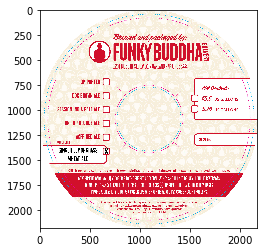

In [33]:
img = np.array(img_raw)
plt.imshow(img)
plt.show()

#### Option 2: direct wrapping (simpler)

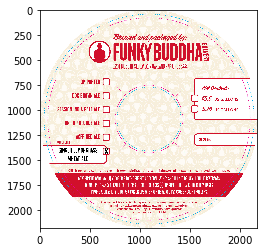

In [55]:
r = requests.get(img_url, headers=headers)
pimg = Image.open(io.BytesIO(r.content))
img = np.array(pimg)
plt.imshow(img)
plt.show()